# Ames Housing Prices Regression - XGBoost

# 1. Introduction

Presented here is a data science challenge featuring the Ames Housing Prices [dataset](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt). This dataset contains information related to the price of houses in Ames, Iowa, U.S.A. The goal is to use regression to estimate the price of unlabeled houses. The presence of different numerical and categorical data types within the set make it a good exercise for exploratory data analysis (EDA).  

In this notebook, the data types will be split into the following categories: 
* Numerical
    * Continuous
    * Discrete 
* Categorical
    * Nominal 
    * Ordinal 

These will be examined using statistical methods and combined into a final dataset for regression training. The regression models to be evaluated here are: 
1. Ridge Regression
2. Random Forest Regression
3. XGBoost Regression

## 1.1 Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_log_error, r2_score
from statistics import mean, mode, median
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kurtosis
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import rcParams
from platform import python_version
print('Python Version: ', python_version())

Python Version:  3.7.10


## 1.2 Configure Settings

In [3]:
RANDOM_SEED = 123
rcParams['figure.figsize'] = (10, 6)
sns.set_theme(palette='muted', style='whitegrid')

## 1.3 Load the Training and Test Files

In [4]:
path = '../input/house-prices-advanced-regression-techniques/train.csv'
df = pd.read_csv(path)
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
path_test = '../input/house-prices-advanced-regression-techniques/test.csv'
df_test = pd.read_csv(path_test)
print(df_test.shape)
df_test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Let's investigate the types of data contained within the training and test sets. You can see they contain a combination of objects, integers, and float values. This will be important when we separate the data into categories.

In [6]:
print(df.dtypes.value_counts(), end='\n' * 2)
print(df_test.dtypes.value_counts())

object     43
int64      35
float64     3
dtype: int64

object     43
int64      26
float64    11
dtype: int64


# 2. EDA of Target Feature

In [7]:
# Check for null values in the target
df['SalePrice'].isnull().any()

False

In [8]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Here we see the `SalePrice` descriptive statistics. The mean is greater than the median which can indicate a positive or right skewed kurtosis. We can confirm this by visualizing the data. 

Kurtosis: 6.509812011089439


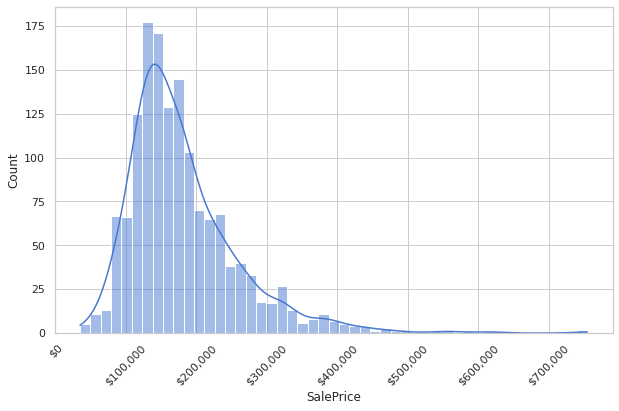

In [9]:
print(f'Kurtosis: {kurtosis(df.SalePrice)}')
ax = sns.histplot(data=df, x='SalePrice', kde=True)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
plt.xticks(rotation=45)
plt.show()


The histogram plot confirms our expectation. This skewed distribution can decline model performance, but a log transformation may reduce kurtosis and improve model performance.  

Kurtosis: 0.8026555069117713


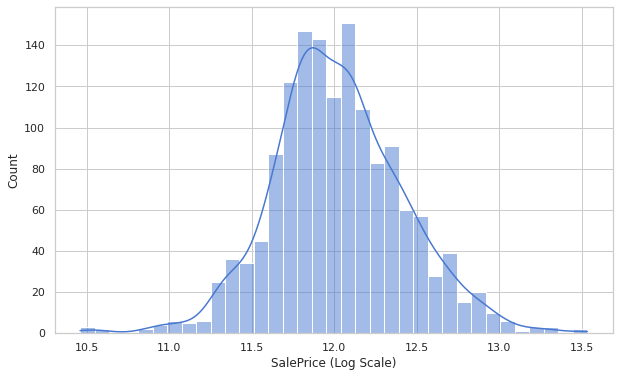

In [10]:
print(f'Kurtosis: {kurtosis(np.log(df.SalePrice))}')
sns.histplot(data=df, x=np.log(df['SalePrice']), kde=True)
plt.xlabel('SalePrice (Log Scale)')
plt.show()

The log transformation was effective at reducing kurtosis in the `SalePrice`.  We will use this later when the models are evaluated. Our next task is to assess any missing values in the rest of the dataset.

# 3. Data Cleaning of Train and Test Sets

We'll set up a small function to return null values from our training and test data.

In [11]:
def null_table(data):    
    null_list = []

    for i in data:
        if data[i].isnull().any():
            null_list.append(data[i].isnull().value_counts())
    
    return pd.DataFrame(pd.concat(null_list, axis=1).T)


In [12]:
# Review null values for the training data
df_null = null_table(df)
print(df_null.shape)
df_null

(19, 2)


,False,True
LotFrontage,1201,259
Alley,91,1369
MasVnrType,1452,8
MasVnrArea,1452,8
BsmtQual,1423,37
BsmtCond,1423,37
BsmtExposure,1422,38
BsmtFinType1,1423,37
BsmtFinType2,1422,38
Electrical,1459,1


It seems there are many missing values, but a closer review of the variable description shows that here the null values have meaning. For example, categorical features describing the basement or garage will be null if the house has neither. However, this is not the case for all the categorical or numerical features. 

In [13]:
# The categorical features are filled with the most frequent value
df['Electrical'] = df.Electrical.fillna(mode(df.Electrical)) 
df['MasVnrType'] = df.MasVnrType.fillna(mode(df.MasVnrType)) 
# The continuous feature is filled with the median value
df['MasVnrArea'] = df.MasVnrArea.fillna(median(df.MasVnrArea)) 
# The discrete feature is filled with zeroes where there is no garage
df['GarageYrBlt'] = df.GarageYrBlt.fillna(0).astype(int) 

In [14]:
# Review null values for the test data
df_test_null = null_table(df_test)
print(df_test_null.shape)
df_test_null

(33, 2)


,False,True
MSZoning,1455,4
LotFrontage,1232,227
Alley,107,1352
Utilities,1457,2
Exterior1st,1458,1
Exterior2nd,1458,1
MasVnrType,1443,16
MasVnrArea,1444,15
BsmtQual,1415,44
BsmtCond,1414,45


With the test data there are more features where the null values are *not* meaningful, so we need to fill these missing entries. The test data will be cleaned using the same method as the training data.

In [15]:
# The categorical features are filled with the most frequent value
df_test['MSZoning'] = df_test.MSZoning.fillna(mode(pd.concat([df['MSZoning'], df_test['MSZoning']], axis=0)))
df_test['Utilities'] = df_test.Utilities.fillna(mode(pd.concat([df['Utilities'], df_test['Utilities']], axis=0)))
df_test['Exterior1st'] = df_test.Exterior1st.fillna(mode(pd.concat([df['Exterior1st'], df_test['Exterior1st']], axis=0)))
df_test['Exterior2nd'] = df_test.Exterior2nd.fillna(mode(pd.concat([df['Exterior2nd'], df_test['Exterior2nd']], axis=0)))
df_test['MasVnrType'] = df_test.MasVnrType.fillna(mode(pd.concat([df['MasVnrType'], df_test['MasVnrType']], axis=0)))
df_test['BsmtFullBath'] = df_test.BsmtFullBath.fillna(mode(pd.concat([df['BsmtFullBath'], df_test['BsmtFullBath']], axis=0)))
df_test['BsmtHalfBath'] = df_test.BsmtHalfBath.fillna(mode(pd.concat([df['BsmtHalfBath'], df_test['BsmtHalfBath']], axis=0)))
df_test['KitchenQual'] = df_test.KitchenQual.fillna(mode(pd.concat([df['KitchenQual'], df_test['KitchenQual']], axis=0)))
df_test['Functional'] = df_test.Functional.fillna(mode(pd.concat([df['Functional'], df_test['Functional']], axis=0)))
df_test['SaleType'] = df_test.SaleType.fillna(mode(pd.concat([df['SaleType'], df_test['SaleType']], axis=0)))
df_test['GarageCars'] = df_test.GarageCars.fillna(mode(pd.concat([df['GarageCars'], df_test['GarageCars']], axis=0)))
# The continuous features are filled with the median value
df_test['GarageArea'] = df_test.GarageArea.fillna(median(pd.concat([df['GarageArea'], df_test['GarageArea']], axis=0)))
df_test['MasVnrArea'] = df_test.MasVnrArea.fillna(median(pd.concat([df['MasVnrArea'], df_test['MasVnrArea']], axis=0)))
df_test['BsmtFinSF1'] = df_test.BsmtFinSF1.fillna(median(pd.concat([df['BsmtFinSF1'], df_test['BsmtFinSF1']], axis=0)))
df_test['BsmtFinSF2'] = df_test.BsmtFinSF2.fillna(median(pd.concat([df['BsmtFinSF2'], df_test['BsmtFinSF2']], axis=0)))
df_test['BsmtUnfSF'] = df_test.BsmtUnfSF.fillna(median(pd.concat([df['BsmtUnfSF'], df_test['BsmtUnfSF']], axis=0)))
df_test['TotalBsmtSF'] = df_test.TotalBsmtSF.fillna(median(pd.concat([df['TotalBsmtSF'], df_test['TotalBsmtSF']], axis=0)))
# The discrete feature is filled with zeroes where there is no garage
df_test['GarageYrBlt'] = df_test.GarageYrBlt.fillna(0).astype(int) 

In [16]:
print(null_table(df).shape)
print(null_table(df_test).shape)

(15, 2)
(15, 2)


The next step is to fill the meaningful null data in the categorical features. We'll name the category `NA`, since this is used in the variable description for houses lacking certain attributes.

In [17]:
# Fill NA data for categorical features
df[[
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]] = df[[
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]].fillna('NA')

df_test[[
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]] = df_test[[
    'Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 
    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'
]].fillna('NA')

The data cleaning stage is completed by dropping `LotFrontage`. Although clever imputation is possible here, there are other features that describe similar aspects of the housing property without a lot of missing entries.

In [18]:
df = df.drop(['LotFrontage'], axis=1)
df_test = df_test.drop(['LotFrontage'], axis=1)

We'll gather all the continuous features into one dataframe for analysis and do the same for the discrete, nominal, and ordinal feature types.

# 4. EDA of Continuous Numerical Features

In [19]:
# Create a dataset of only continuous data
df_continuous = df[[
    'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
    'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
    'MiscVal'
]]

df_test_continuous = df_test[[
    'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
    'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
    'MiscVal'
]]

In [20]:
print(df_continuous.shape)
df_continuous.head()

(1460, 17)


,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0
1,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0
2,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0
3,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0
4,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0


In [21]:
print(df_test_continuous.shape)
df_test_continuous.head()

(1459, 17)


,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
0,11622,0.0,468.0,144.0,270.0,882.0,896,0,0,896,730.0,140,0,0,0,120,0
1,14267,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,312.0,393,36,0,0,0,12500
2,13830,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,482.0,212,34,0,0,0,0
3,9978,20.0,602.0,0.0,324.0,926.0,926,678,0,1604,470.0,360,36,0,0,0,0
4,5005,0.0,263.0,0.0,1017.0,1280.0,1280,0,0,1280,506.0,0,82,0,0,144,0


Next task is  to visualize the continuous features using the median sale price for color coding. This can show us the importance of certain features in terms of high or low sale prices. Also the coefficient of determination (r-squared) will be calculated to complement our observations.

In [22]:
# Create a boolean feature for houses sold above the median price
df['PriceAbvMedian'] = df['SalePrice'].apply(lambda x: 0 if x < median(df.SalePrice) else 1)

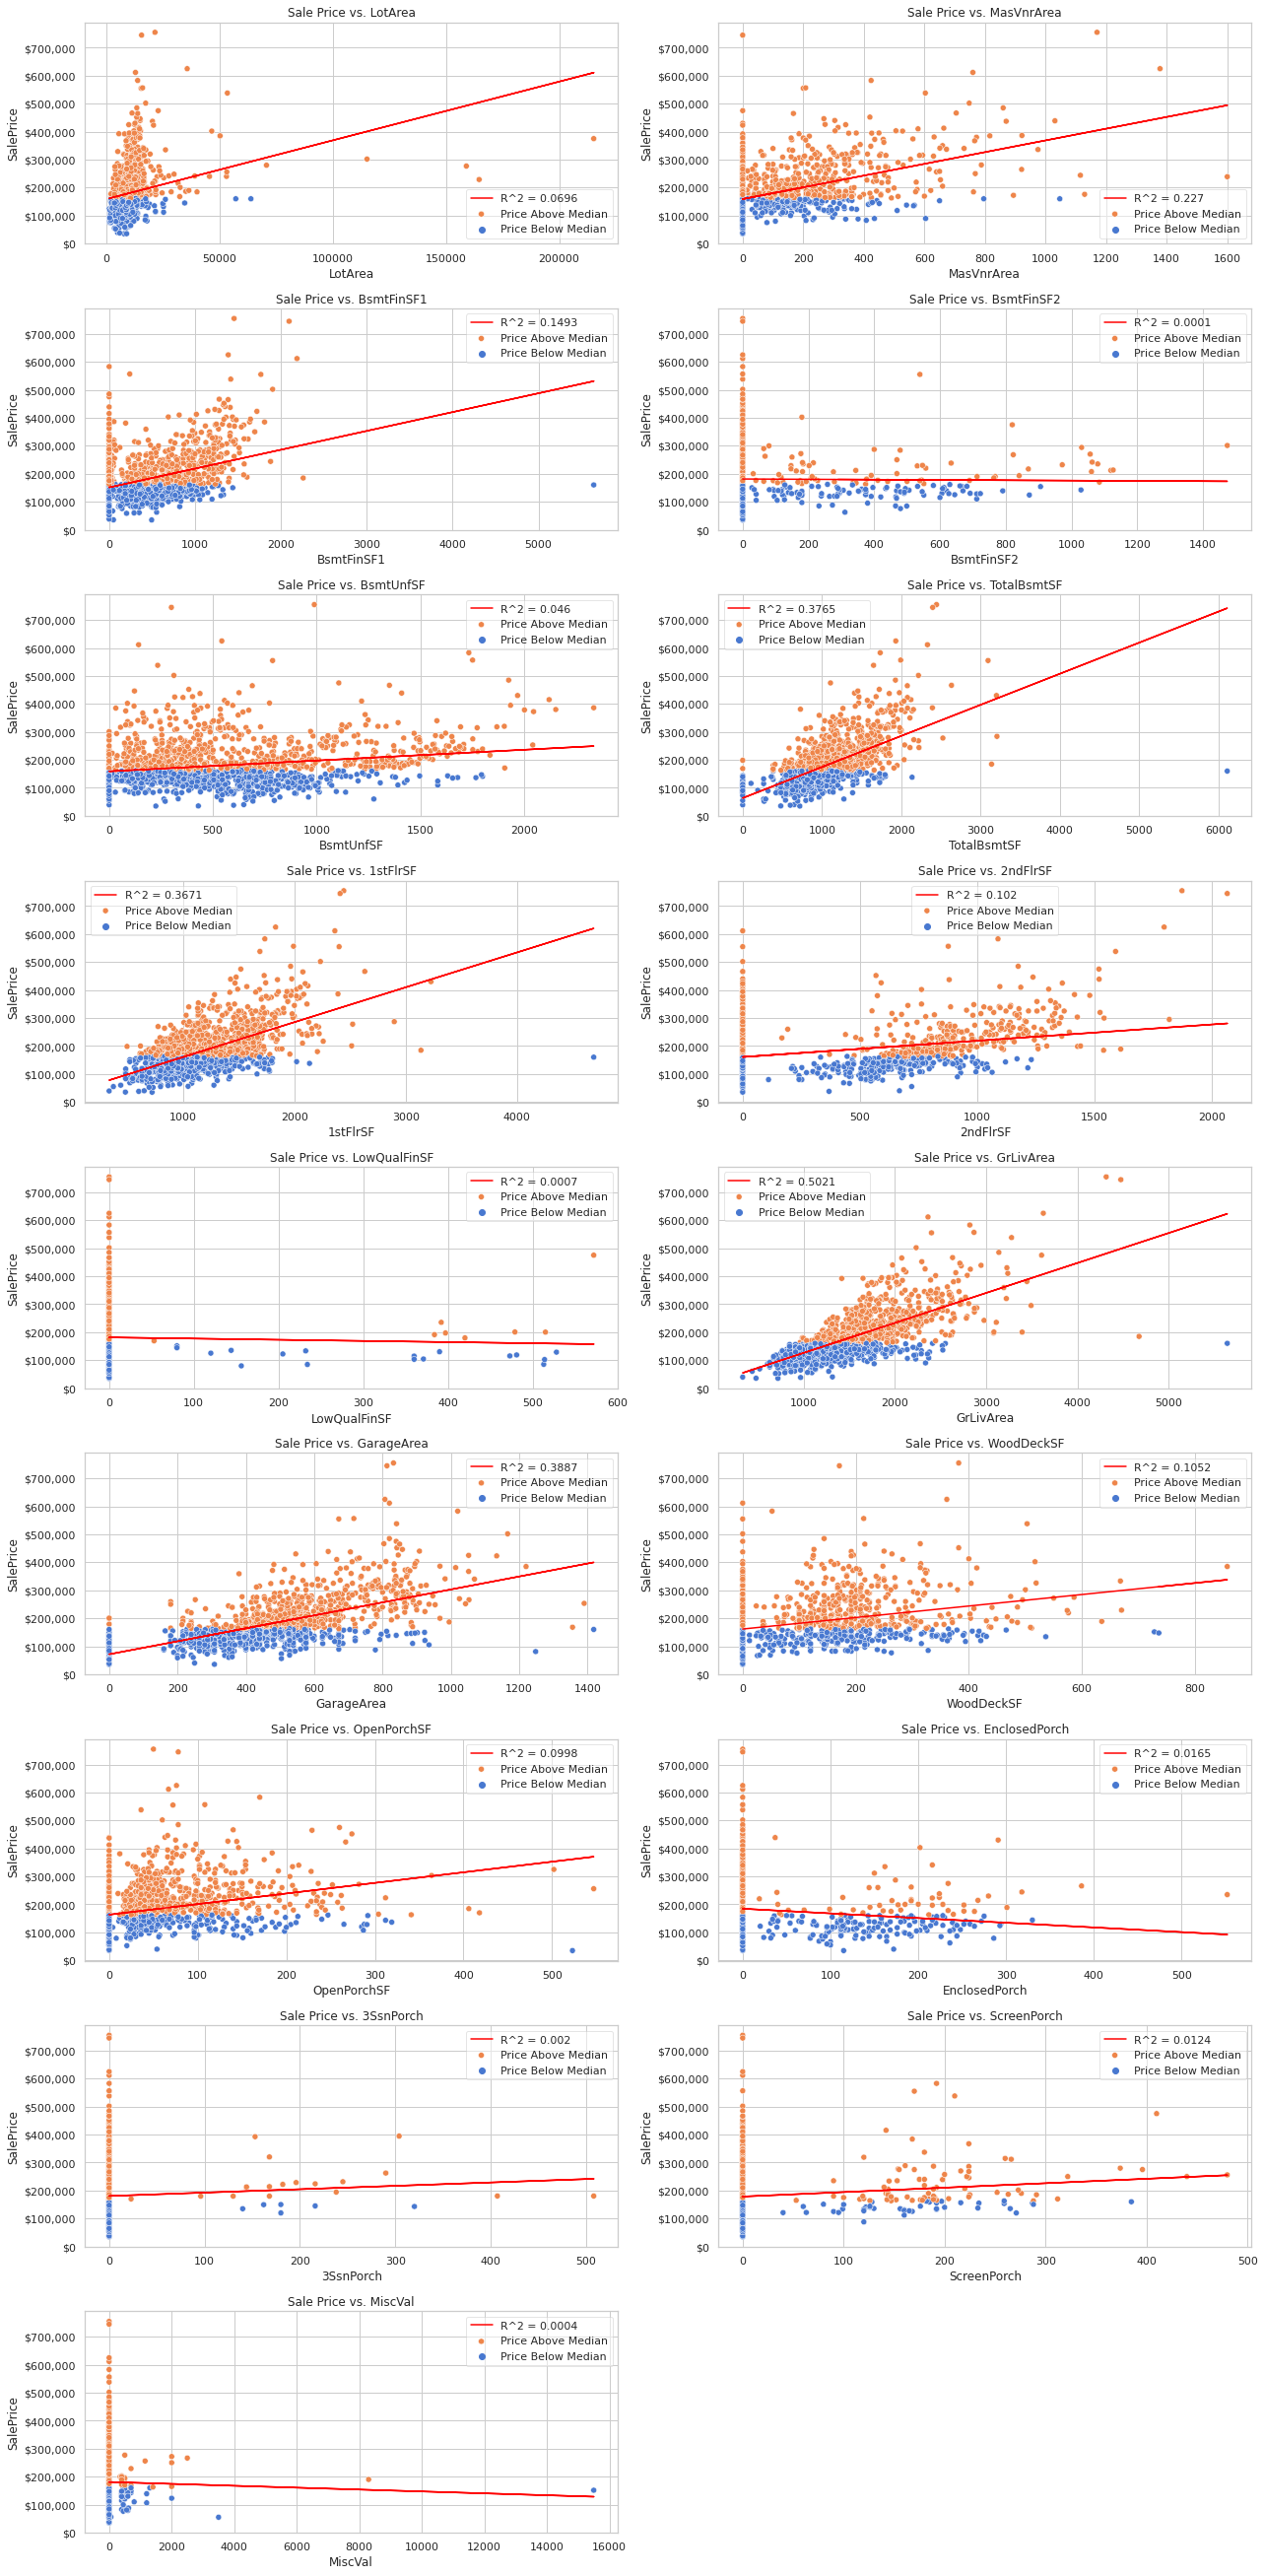

In [23]:
# Plot all continuous features
plt.figure(figsize=(18, 40))

for i, j in enumerate(df_continuous.columns):
    plt.subplot(10, 2, i + 1)
    ax = sns.scatterplot(data=df, x=f'{j}', y='SalePrice', hue='PriceAbvMedian')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    plt.title(f'Sale Price vs. {j}')
    # Plot the best fit line
    m, b = np.polyfit(x=df[j], y=df.SalePrice, deg=1)
    plt.plot(df[j], m * df[j] + b, c='red')
    # Plot the r-squared value
    corr_matrix = np.corrcoef(df[j], df.SalePrice)    
    corr_xy = corr_matrix[0,1]
    r_squared = round((corr_xy ** 2), 4)    
    plt.legend(labels=[f'R^2 = {r_squared}', 'Price Above Median', 'Price Below Median'], framealpha=0.5, loc=0)
    
plt.tight_layout()
plt.show()

`GrLivArea` has the highest r-squared score. We'll plot a correlation table and sort by the `SalePrice` to better understand how these features rank in relation to the `SalePrice`. 

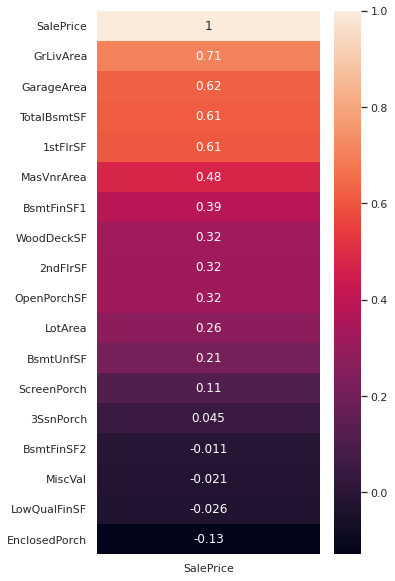

In [24]:
plt.figure(figsize=(5, 10))
sns.heatmap(pd.DataFrame(pd.concat([df['SalePrice'], df_continuous], axis=1).corr()[['SalePrice']].sort_values(by=['SalePrice'], ascending=False)), annot=True)
plt.show()

A function is created to return a kurtosis table for each feature. We can understand the skewness of each feature which will help us decide which scaling method to use.

In [25]:
def get_kurtosis(data):
    df_kurt = pd.DataFrame()
    df_kurt['Variable'] = data.columns

    for i in data.columns:
        df_kurt['Kurtosis'] = [kurtosis(data[f'{i}']) for i in data.columns]

    return df_kurt.sort_values(by=['Kurtosis'], ascending=False)

In [26]:
get_kurtosis(df_continuous)

,Variable,Kurtosis
16,MiscVal,698.600840
0,LotArea,202.543793
14,3SsnPorch,123.235177
8,LowQualFinSF,82.945932
3,BsmtFinSF2,20.040415
15,ScreenPorch,18.371874
5,TotalBsmtSF,13.201042
2,BsmtFinSF1,11.076090
13,EnclosedPorch,10.390972
1,MasVnrArea,10.077038


Kurtosis is high in features such as `MiscVal` and `LotAreaa`, but low in `BsmtUnfSF`. We'll move on to the next feature group and see what we can learn about the data.

# 5. EDA of Discrete Numerical Features

In [27]:
# Create a dataset of only discrete data
df_discrete = df[[
    'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageYrBlt', 
    'MoSold', 'YrSold'
]]

df_test_discrete = df_test[[
    'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
    'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageYrBlt', 
    'MoSold', 'YrSold'
]]

In [28]:
print(df_discrete.shape)
df_discrete.head()

(1460, 14)


,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageYrBlt,MoSold,YrSold
0,2003,2003,1,0,2,1,3,1,8,0,2,2003,2,2008
1,1976,1976,0,1,2,0,3,1,6,1,2,1976,5,2007
2,2001,2002,1,0,2,1,3,1,6,1,2,2001,9,2008
3,1915,1970,1,0,1,0,3,1,7,1,3,1998,2,2006
4,2000,2000,1,0,2,1,4,1,9,1,3,2000,12,2008


In [29]:
print(df_test_discrete.shape)
df_test_discrete.head()

(1459, 14)


,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageYrBlt,MoSold,YrSold
0,1961,1961,0.0,0.0,1,0,2,1,5,0,1.0,1961,6,2010
1,1958,1958,0.0,0.0,1,1,3,1,6,0,1.0,1958,6,2010
2,1997,1998,0.0,0.0,2,1,3,1,6,1,2.0,1997,3,2010
3,1998,1998,0.0,0.0,2,1,3,1,7,1,2.0,1998,6,2010
4,1992,1992,0.0,0.0,2,0,2,1,5,0,2.0,1992,1,2010


We'll use the median price color coding again, this time with a histogram to identify any trends in the discrete data.

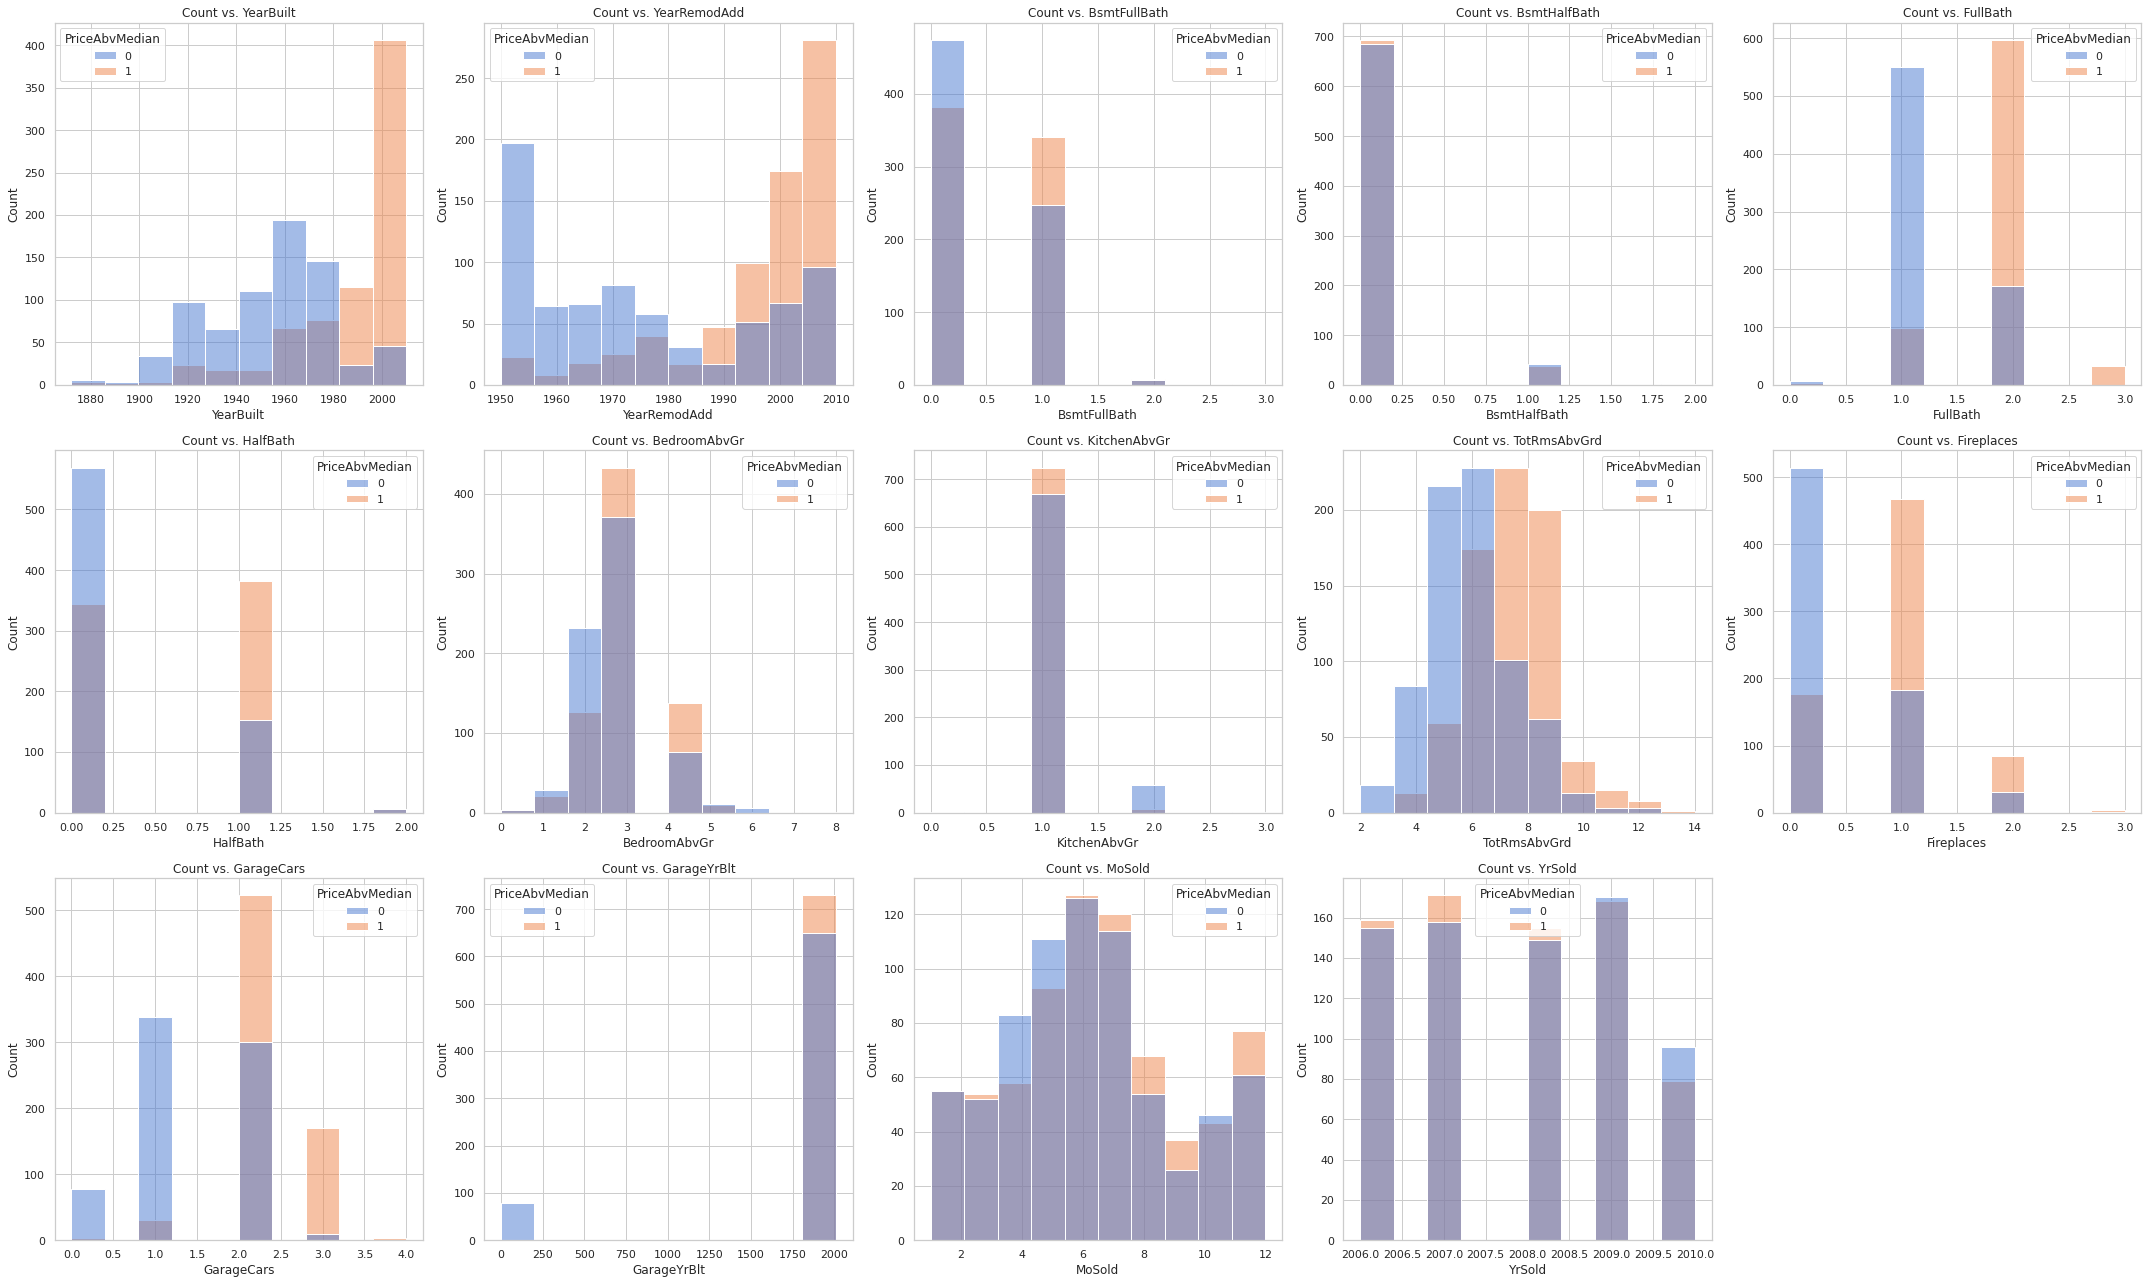

In [30]:
# Plot all discrete features
plt.figure(figsize=(30, 18))

for i, j in enumerate(df_discrete.columns):
    count, bin_edges = np.histogram(df[f'{j}']) # Acquire bin edges
    plt.subplot(3, 5, i + 1)
    sns.histplot(data=df, x=f'{j}', bins=bin_edges, hue='PriceAbvMedian')
    plt.title(f'Count vs. {j}')
plt.tight_layout()
plt.show()

<AxesSubplot:>

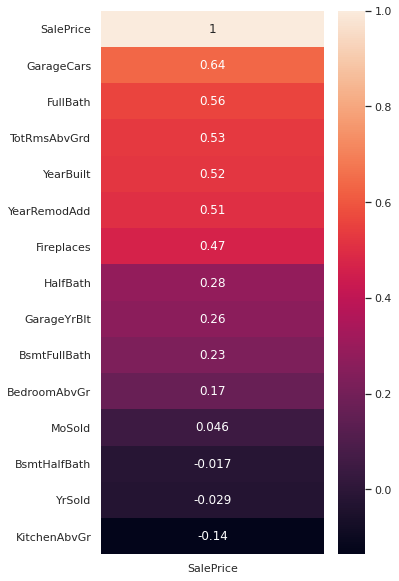

In [31]:
plt.figure(figsize=(5, 10))
sns.heatmap(pd.DataFrame(pd.concat([df['SalePrice'], df_discrete], axis=1).corr()[['SalePrice']].sort_values(by=['SalePrice'], ascending=False)), annot=True)

In [32]:
get_kurtosis(df_discrete)

,Variable,Kurtosis
7,KitchenAbvGr,21.454627
3,BsmtHalfBath,16.336436
11,GarageYrBlt,12.994493
6,BedroomAbvGr,2.219135
8,TotRmsAbvGrd,0.873641
10,GarageCars,0.216135
9,Fireplaces,-0.220601
12,MoSold,-0.406834
0,YearBuilt,-0.442155
2,BsmtFullBath,-0.840334


# 6. EDA of Nominal Categorical Features

In [33]:
# Create a dataset for only nominal data
df_nominal = df[[
    'Alley', 'GarageType', 'MiscFeature',
    'MSZoning', 'MSSubClass', 'Street', 'LandContour',
    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
    'Heating', 'CentralAir', 'SaleType', 'SaleCondition'    
]]

df_test_nominal = df_test[[
    'Alley', 'GarageType', 'MiscFeature',
    'MSZoning', 'MSSubClass', 'Street', 'LandContour',
    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
    'Heating', 'CentralAir', 'SaleType', 'SaleCondition'    
]]

In [34]:
print(df_nominal.shape)
df_nominal.head()

(1460, 23)


,Alley,GarageType,MiscFeature,MSZoning,MSSubClass,Street,LandContour,LotConfig,Neighborhood,Condition1,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,NA,Attchd,NA,RL,60,Pave,Lvl,Inside,CollgCr,Norm,...,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,WD,Normal
1,NA,Attchd,NA,RL,20,Pave,Lvl,FR2,Veenker,Feedr,...,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,WD,Normal
2,NA,Attchd,NA,RL,60,Pave,Lvl,Inside,CollgCr,Norm,...,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,WD,Normal
3,NA,Detchd,NA,RL,70,Pave,Lvl,Corner,Crawfor,Norm,...,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,WD,Abnorml
4,NA,Attchd,NA,RL,60,Pave,Lvl,FR2,NoRidge,Norm,...,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,WD,Normal


In [35]:
print(df_test_nominal.shape)
df_test_nominal.head()

(1459, 23)


,Alley,GarageType,MiscFeature,MSZoning,MSSubClass,Street,LandContour,LotConfig,Neighborhood,Condition1,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,NA,Attchd,NA,RH,20,Pave,Lvl,Inside,NAmes,Feedr,...,Gable,CompShg,VinylSd,VinylSd,None,CBlock,GasA,Y,WD,Normal
1,NA,Attchd,Gar2,RL,20,Pave,Lvl,Corner,NAmes,Norm,...,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,CBlock,GasA,Y,WD,Normal
2,NA,Attchd,NA,RL,60,Pave,Lvl,Inside,Gilbert,Norm,...,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,Y,WD,Normal
3,NA,Attchd,NA,RL,60,Pave,Lvl,Inside,Gilbert,Norm,...,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,WD,Normal
4,NA,Attchd,NA,RL,120,Pave,HLS,Inside,StoneBr,Norm,...,Gable,CompShg,HdBoard,HdBoard,None,PConc,GasA,Y,WD,Normal


The nominal features are analyzed using a boxplot.  This will give us information on the skewness, range, and median values of the feature categories.

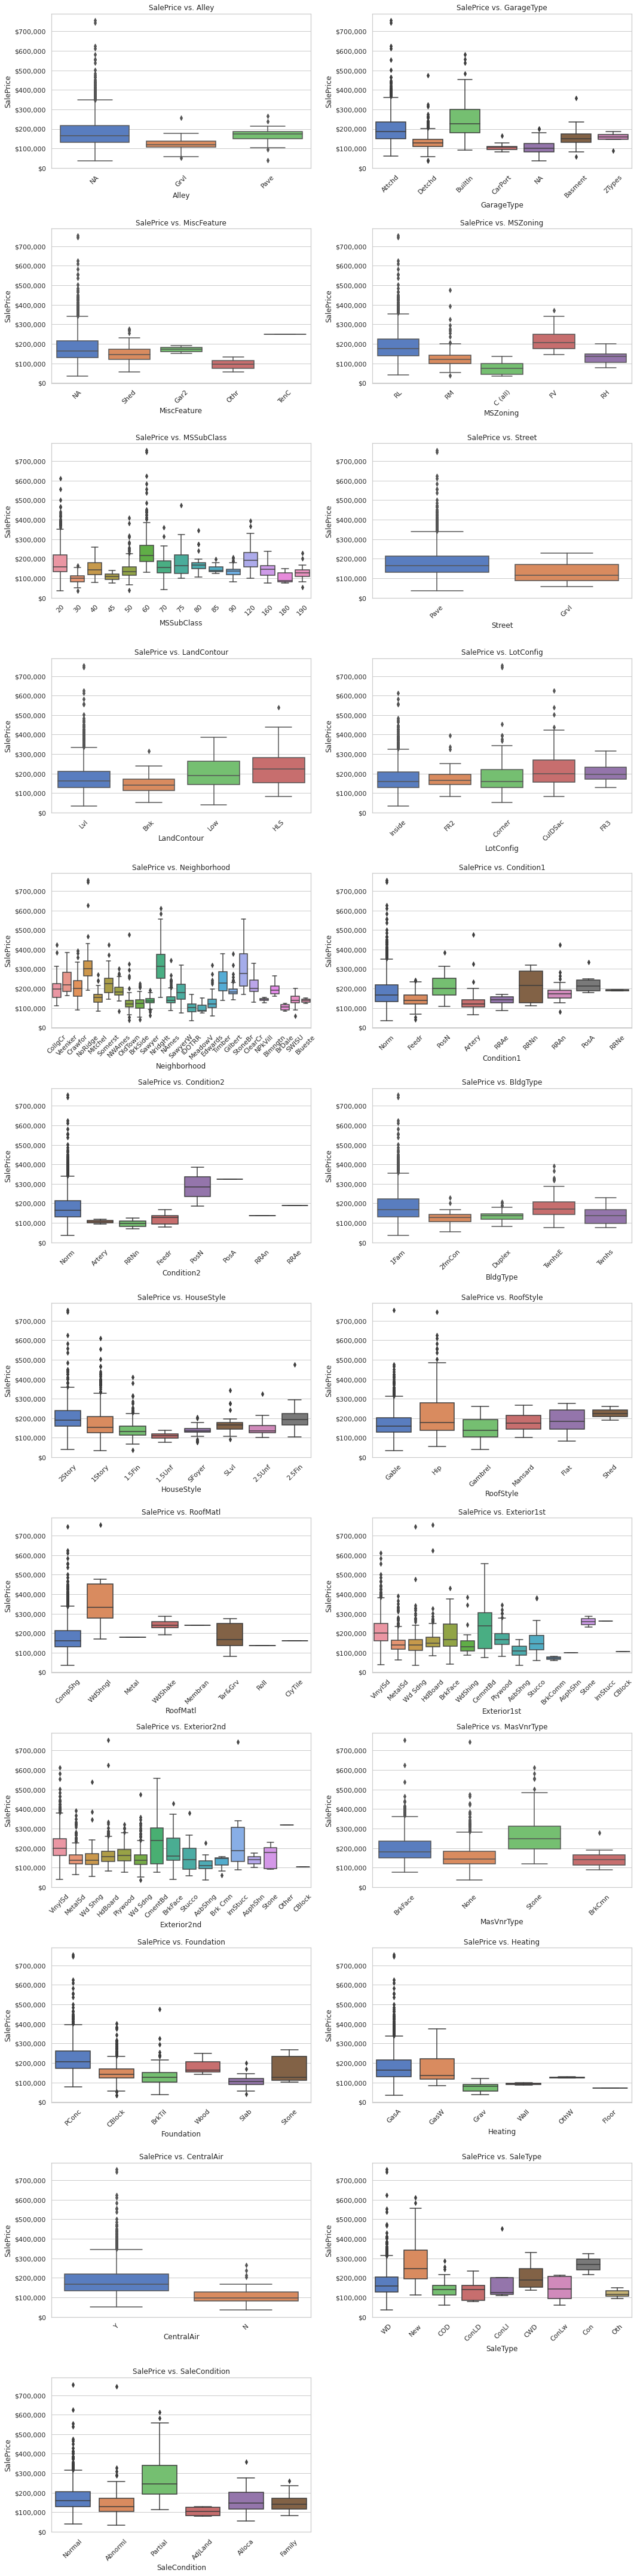

In [36]:
# Plot all nominal features
plt.figure(figsize=(15, 60))

for i, j in enumerate(df_nominal.columns):
    plt.subplot(12, 2, i + 1)
    ax = sns.boxplot(data=df, x=f'{j}', y=df.SalePrice)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    plt.xticks(rotation=45)
    plt.title(f'SalePrice vs. {j}')
    
plt.tight_layout()
plt.show()

Transformation of the nominal data will be done by ordinal encoding. This dataset already contains a number of features that describe similar elements of the housing property. 

One-Hot-Encoding could worsen this problem by adding redundant features to the dataset. This could increase [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and make it more difficult to determine the effects of individual features on the target variable. 

In [37]:
# Encode the nominal data into numerical data
encoder_nominal = OrdinalEncoder()
df_nominal_ord = pd.DataFrame(encoder_nominal.fit_transform(df_nominal))
df_nominal_ord.columns = [
    'Alley', 'GarageType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Street', 'LandContour',
    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
    'Heating', 'CentralAir', 'SaleType', 'SaleCondition'
]  

encoder_nominal_test = OrdinalEncoder()
df_test_nominal_ord = pd.DataFrame(encoder_nominal_test.fit_transform(df_test_nominal))
df_test_nominal_ord.columns = [
    'Alley', 'GarageType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Street', 'LandContour',
    'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
    'Heating', 'CentralAir', 'SaleType', 'SaleCondition'
]

In [38]:
print(df_nominal_ord.shape)
df_nominal_ord.head()

(1460, 23)


,Alley,GarageType,MiscFeature,MSSubClass,MSZoning,Street,LandContour,LotConfig,Neighborhood,Condition1,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,1.0,1.0,1.0,3.0,5.0,1.0,3.0,4.0,5.0,2.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0
1,1.0,1.0,1.0,3.0,0.0,1.0,3.0,2.0,24.0,1.0,...,1.0,1.0,8.0,8.0,2.0,1.0,1.0,1.0,8.0,4.0
2,1.0,1.0,1.0,3.0,5.0,1.0,3.0,4.0,5.0,2.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0
3,1.0,5.0,1.0,3.0,6.0,1.0,3.0,0.0,6.0,2.0,...,1.0,1.0,13.0,15.0,2.0,0.0,1.0,1.0,8.0,0.0
4,1.0,1.0,1.0,3.0,5.0,1.0,3.0,2.0,15.0,2.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0


In [39]:
print(df_test_nominal_ord.shape)
df_test_nominal_ord.head()

(1459, 23)


,Alley,GarageType,MiscFeature,MSSubClass,MSZoning,Street,LandContour,LotConfig,Neighborhood,Condition1,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,1.0,1.0,1.0,2.0,0.0,1.0,3.0,4.0,12.0,1.0,...,1.0,0.0,10.0,12.0,2.0,1.0,0.0,1.0,8.0,4.0
1,1.0,1.0,0.0,3.0,0.0,1.0,3.0,0.0,12.0,2.0,...,3.0,0.0,11.0,13.0,1.0,1.0,0.0,1.0,8.0,4.0
2,1.0,1.0,1.0,3.0,5.0,1.0,3.0,4.0,8.0,2.0,...,1.0,0.0,10.0,12.0,2.0,2.0,0.0,1.0,8.0,4.0
3,1.0,1.0,1.0,3.0,5.0,1.0,3.0,4.0,8.0,2.0,...,1.0,0.0,10.0,12.0,1.0,2.0,0.0,1.0,8.0,4.0
4,1.0,1.0,1.0,3.0,11.0,1.0,1.0,4.0,22.0,2.0,...,1.0,0.0,6.0,6.0,2.0,2.0,0.0,1.0,8.0,4.0


<AxesSubplot:>

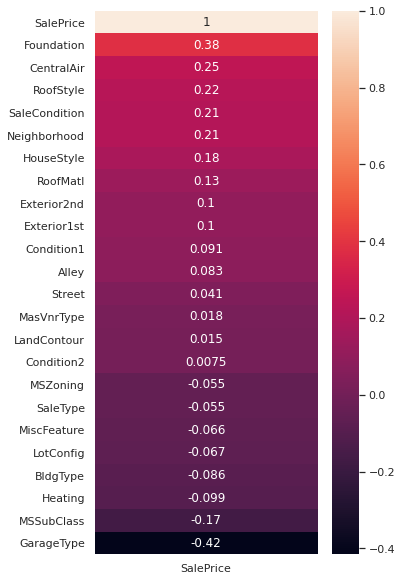

In [40]:
plt.figure(figsize=(5, 10))
sns.heatmap(pd.DataFrame(pd.concat([df['SalePrice'], df_nominal_ord], axis=1).corr()[['SalePrice']].sort_values(by=['SalePrice'], ascending=False)), annot=True)

In [41]:
get_kurtosis(df_nominal_ord)

,Variable,Kurtosis
10,Condition2,247.880615
5,Street,238.337460
19,Heating,111.135862
14,RoofMatl,66.372840
2,MiscFeature,24.152644
9,Condition1,16.368728
21,SaleType,14.899365
0,Alley,13.028025
20,CentralAir,10.438018
6,LandContour,8.661773


# 7. EDA of Ordinal Categorical Features

In [42]:
# Create a dataset of only ordinal data
df_ordinal = df[[
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'LotShape', 'Utilities', 'LandSlope', 
    'OverallQual', 'OverallCond', 'ExterQual', 
    'ExterCond', 'HeatingQC', 'Electrical', 
    'KitchenQual', 'Functional', 'PavedDrive', 
    'PoolQC', 'Fence'
]]

df_test_ordinal = df_test[[
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'LotShape', 'Utilities', 'LandSlope', 
    'OverallQual', 'OverallCond', 'ExterQual', 
    'ExterCond', 'HeatingQC', 'Electrical', 
    'KitchenQual', 'Functional', 'PavedDrive', 
    'PoolQC', 'Fence'
]]

In [43]:
print(df_ordinal.shape)
df_ordinal.head()

(1460, 23)


,BsmtQual,BsmtCond,BsmtExposure,GarageFinish,GarageQual,GarageCond,BsmtFinType1,BsmtFinType2,FireplaceQu,LotShape,...,OverallCond,ExterQual,ExterCond,HeatingQC,Electrical,KitchenQual,Functional,PavedDrive,PoolQC,Fence
0,Gd,TA,No,RFn,TA,TA,GLQ,Unf,NA,Reg,...,5,Gd,TA,Ex,SBrkr,Gd,Typ,Y,NA,NA
1,Gd,TA,Gd,RFn,TA,TA,ALQ,Unf,TA,Reg,...,8,TA,TA,Ex,SBrkr,TA,Typ,Y,NA,NA
2,Gd,TA,Mn,RFn,TA,TA,GLQ,Unf,TA,IR1,...,5,Gd,TA,Ex,SBrkr,Gd,Typ,Y,NA,NA
3,TA,Gd,No,Unf,TA,TA,ALQ,Unf,Gd,IR1,...,5,TA,TA,Gd,SBrkr,Gd,Typ,Y,NA,NA
4,Gd,TA,Av,RFn,TA,TA,GLQ,Unf,TA,IR1,...,5,Gd,TA,Ex,SBrkr,Gd,Typ,Y,NA,NA


In [44]:
print(df_test_ordinal.shape)
df_test_ordinal.head()

(1459, 23)


,BsmtQual,BsmtCond,BsmtExposure,GarageFinish,GarageQual,GarageCond,BsmtFinType1,BsmtFinType2,FireplaceQu,LotShape,...,OverallCond,ExterQual,ExterCond,HeatingQC,Electrical,KitchenQual,Functional,PavedDrive,PoolQC,Fence
0,TA,TA,No,Unf,TA,TA,Rec,LwQ,NA,Reg,...,6,TA,TA,TA,SBrkr,TA,Typ,Y,NA,MnPrv
1,TA,TA,No,Unf,TA,TA,ALQ,Unf,NA,IR1,...,6,TA,TA,TA,SBrkr,Gd,Typ,Y,NA,NA
2,Gd,TA,No,Fin,TA,TA,GLQ,Unf,TA,IR1,...,5,TA,TA,Gd,SBrkr,TA,Typ,Y,NA,MnPrv
3,TA,TA,No,Fin,TA,TA,GLQ,Unf,Gd,IR1,...,6,TA,TA,Ex,SBrkr,Gd,Typ,Y,NA,NA
4,Gd,TA,No,RFn,TA,TA,ALQ,Unf,NA,IR1,...,5,Gd,TA,Ex,SBrkr,Gd,Typ,Y,NA,NA


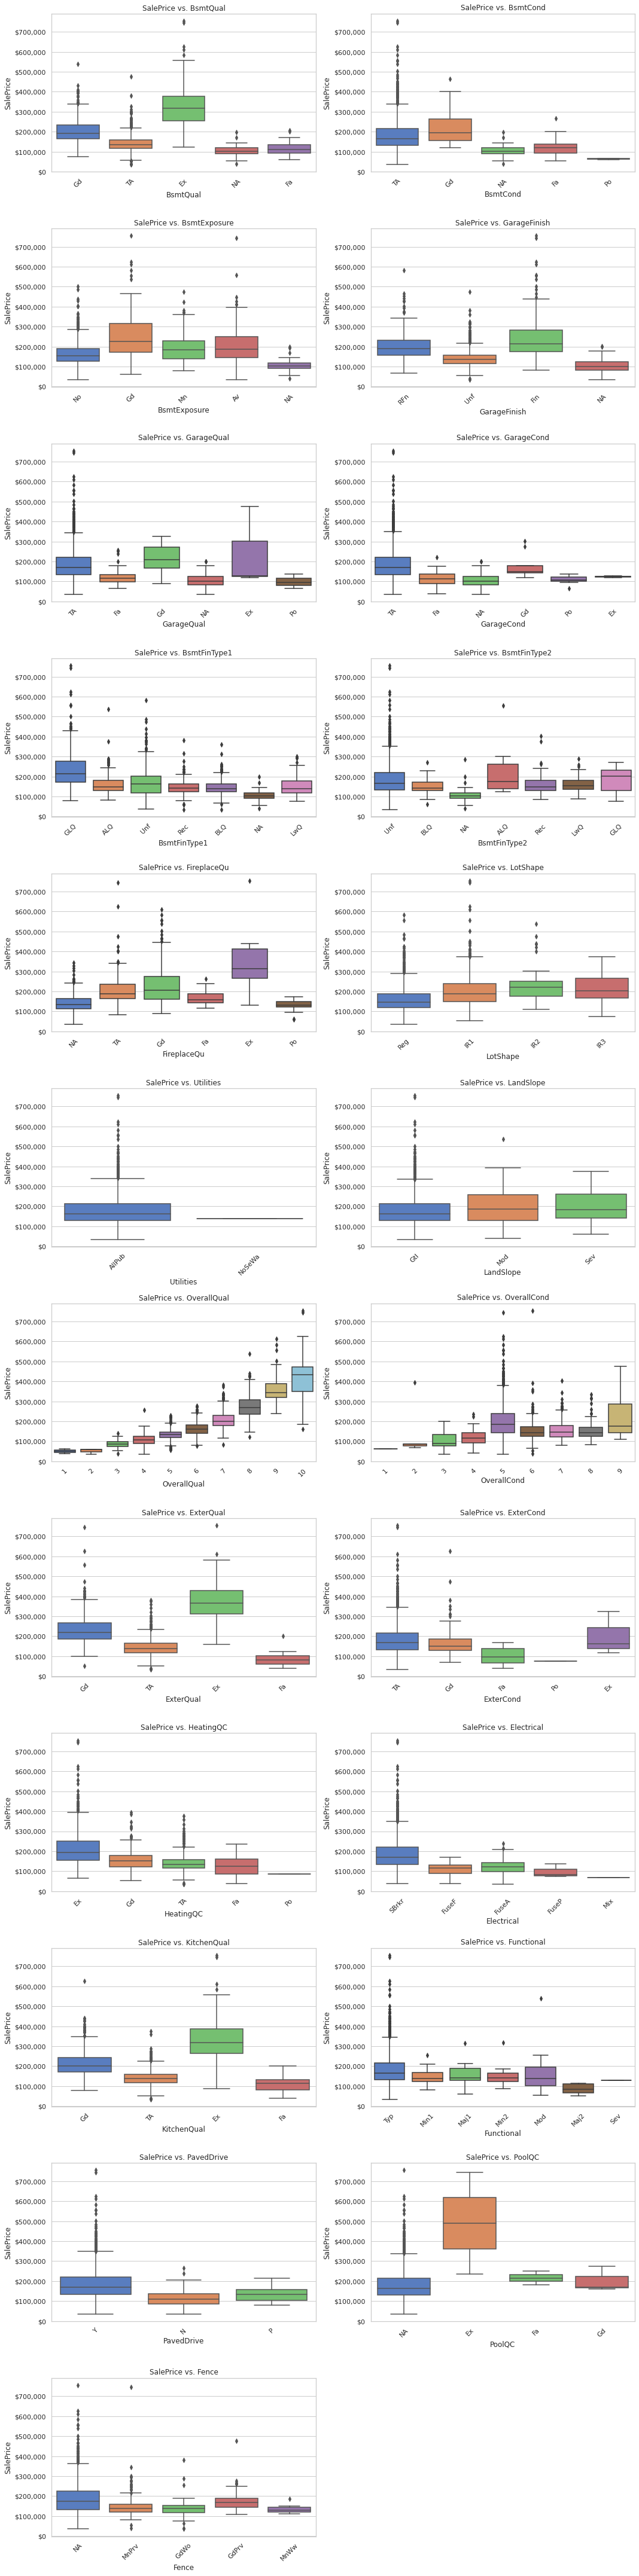

In [45]:
# Plot all ordinal features
plt.figure(figsize=(15, 60))

for i, j in enumerate(df_ordinal.columns):
    plt.subplot(12, 2, i + 1)
    ax = sns.boxplot(data=df, x=f'{j}', y=df.SalePrice)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    plt.xticks(rotation=45)
    plt.title(f'SalePrice vs. {j}')
plt.tight_layout()
plt.show()

We'll use the `OrdinalEncoder` again to transform the ordinal data. This will make it so the model can understand degrees of order or class among the feature variables. 

In [46]:
# Encode the ordinal data into numerical data
encoder = OrdinalEncoder()
df_ordinal = pd.DataFrame(encoder.fit_transform(df_ordinal))
df_ordinal.columns = [    
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'LotShape', 'Utilities', 'LandSlope', 
    'OverallQual', 'OverallCond', 'ExterQual', 
    'ExterCond', 'HeatingQC', 'Electrical', 
    'KitchenQual', 'Functional', 'PavedDrive', 
    'PoolQC', 'Fence'
]

encoder_test = OrdinalEncoder()
df_test_ordinal = pd.DataFrame(encoder_test.fit_transform(df_test_ordinal))
df_test_ordinal.columns = [    
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
    'LotShape', 'Utilities', 'LandSlope', 
    'OverallQual', 'OverallCond', 'ExterQual', 
    'ExterCond', 'HeatingQC', 'Electrical', 
    'KitchenQual', 'Functional', 'PavedDrive', 
    'PoolQC', 'Fence'
]

In [47]:
print(df_ordinal.shape)
df_ordinal.head()

(1460, 23)


,BsmtQual,BsmtCond,BsmtExposure,GarageFinish,GarageQual,GarageCond,BsmtFinType1,BsmtFinType2,FireplaceQu,LotShape,...,OverallCond,ExterQual,ExterCond,HeatingQC,Electrical,KitchenQual,Functional,PavedDrive,PoolQC,Fence
0,2.0,4.0,4.0,2.0,5.0,5.0,2.0,6.0,3.0,3.0,...,4.0,2.0,4.0,0.0,4.0,2.0,6.0,2.0,3.0,4.0
1,2.0,4.0,1.0,2.0,5.0,5.0,0.0,6.0,5.0,3.0,...,7.0,3.0,4.0,0.0,4.0,3.0,6.0,2.0,3.0,4.0
2,2.0,4.0,2.0,2.0,5.0,5.0,2.0,6.0,5.0,0.0,...,4.0,2.0,4.0,0.0,4.0,2.0,6.0,2.0,3.0,4.0
3,4.0,1.0,4.0,3.0,5.0,5.0,0.0,6.0,2.0,0.0,...,4.0,3.0,4.0,2.0,4.0,2.0,6.0,2.0,3.0,4.0
4,2.0,4.0,0.0,2.0,5.0,5.0,2.0,6.0,5.0,0.0,...,4.0,2.0,4.0,0.0,4.0,2.0,6.0,2.0,3.0,4.0


In [48]:
print(df_test_ordinal.shape)
df_test_ordinal.head()

(1459, 23)


,BsmtQual,BsmtCond,BsmtExposure,GarageFinish,GarageQual,GarageCond,BsmtFinType1,BsmtFinType2,FireplaceQu,LotShape,...,OverallCond,ExterQual,ExterCond,HeatingQC,Electrical,KitchenQual,Functional,PavedDrive,PoolQC,Fence
0,4.0,4.0,4.0,3.0,4.0,5.0,5.0,3.0,3.0,3.0,...,5.0,3.0,4.0,4.0,3.0,3.0,6.0,2.0,2.0,2.0
1,4.0,4.0,4.0,3.0,4.0,5.0,0.0,6.0,3.0,0.0,...,5.0,3.0,4.0,4.0,3.0,2.0,6.0,2.0,2.0,4.0
2,2.0,4.0,4.0,0.0,4.0,5.0,2.0,6.0,5.0,0.0,...,4.0,3.0,4.0,2.0,3.0,3.0,6.0,2.0,2.0,2.0
3,4.0,4.0,4.0,0.0,4.0,5.0,2.0,6.0,2.0,0.0,...,5.0,3.0,4.0,0.0,3.0,2.0,6.0,2.0,2.0,4.0
4,2.0,4.0,4.0,2.0,4.0,5.0,0.0,6.0,3.0,0.0,...,4.0,2.0,4.0,0.0,3.0,2.0,6.0,2.0,2.0,4.0


<AxesSubplot:>

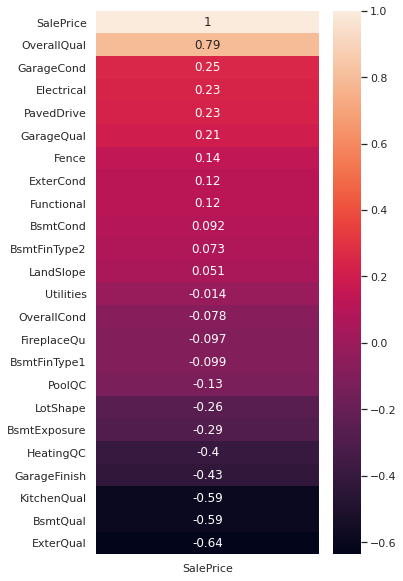

In [49]:
plt.figure(figsize=(5, 10))
sns.heatmap(pd.DataFrame(pd.concat([df['SalePrice'], df_ordinal], axis=1).corr()[['SalePrice']].sort_values(by=['SalePrice'], ascending=False)), annot=True)

In [50]:
get_kurtosis(df_ordinal)

,Variable,Kurtosis
10,Utilities,1455.000685
21,PoolQC,337.218390
11,LandSlope,24.509341
19,Functional,16.401400
5,GarageCond,12.467276
4,GarageQual,9.734347
7,BsmtFinType2,9.461872
20,PavedDrive,9.237297
17,Electrical,7.508445
1,BsmtCond,7.185992


# 8. Preprocessing of the Training Dataset

We now have 4 different datasets. They will be concatenated into a single training dataset for processing.

In [51]:
# Concatenate all the datasets into one
df_concat = pd.concat([ 
    df_continuous, 
    df_discrete,
    df_ordinal, 
    df_nominal_ord
], axis=1).astype(float)

df_test_concat = pd.concat([ 
    df_test_continuous, 
    df_test_discrete, 
    df_test_ordinal, 
    df_test_nominal_ord
], axis=1).astype(float)

The training and test datasets should have the same shape.

In [52]:
print(df_concat.shape)
df_concat.head()

(1460, 77)


,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,8450.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0
1,9600.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,...,1.0,1.0,8.0,8.0,2.0,1.0,1.0,1.0,8.0,4.0
2,11250.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0
3,9550.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,...,1.0,1.0,13.0,15.0,2.0,0.0,1.0,1.0,8.0,0.0
4,14260.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0


In [53]:
print(df_test_concat.shape)
df_test_concat.head()

(1459, 77)


,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,11622.0,0.0,468.0,144.0,270.0,882.0,896.0,0.0,0.0,896.0,...,1.0,0.0,10.0,12.0,2.0,1.0,0.0,1.0,8.0,4.0
1,14267.0,108.0,923.0,0.0,406.0,1329.0,1329.0,0.0,0.0,1329.0,...,3.0,0.0,11.0,13.0,1.0,1.0,0.0,1.0,8.0,4.0
2,13830.0,0.0,791.0,0.0,137.0,928.0,928.0,701.0,0.0,1629.0,...,1.0,0.0,10.0,12.0,2.0,2.0,0.0,1.0,8.0,4.0
3,9978.0,20.0,602.0,0.0,324.0,926.0,926.0,678.0,0.0,1604.0,...,1.0,0.0,10.0,12.0,1.0,2.0,0.0,1.0,8.0,4.0
4,5005.0,0.0,263.0,0.0,1017.0,1280.0,1280.0,0.0,0.0,1280.0,...,1.0,0.0,6.0,6.0,2.0,2.0,0.0,1.0,8.0,4.0


## 8.1 Calculate the Variance Inflation Factors

The [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF) tells us the degree to which an estimated regression coefficient's variance increases because of collinearity. This is applied when we want to know how strongly our data features correlate with each other. Too strong of a correlation between them can affect regression results. We begin this process by building a function to return a VIF table.

In [54]:
# Get the VIF statistics
def get_vif(data):
    
    df_vars = pd.DataFrame(np.log1p(data))
    # Include the intercept constant 
    df_vars_const = sma.add_constant(df_vars)
    df_vif = pd.DataFrame()
    df_vif['Feature'] = df_vars_const.columns
    df_vif['VIF'] = [variance_inflation_factor(df_vars_const.values, i) for i in range(df_vars_const.shape[1])]
    # Return the 25 highest VIF values
    return df_vif.sort_values(by=['VIF'], ascending=False).head(25)

In [55]:
get_vif(df_concat)

,Feature,VIF
0,const,1.473224e+08
11,GarageArea,7.164226e+01
29,GarageYrBlt,4.317993e+01
10,GrLivArea,3.444036e+01
8,2ndFlrSF,2.390380e+01
7,1stFlrSF,2.111551e+01
28,GarageCars,1.030582e+01
18,YearBuilt,7.436365e+00
26,TotRmsAbvGrd,5.232756e+00
59,MSZoning,4.847157e+00


There are different guidelines about the best threshold for VIF:
* VIF < 10
* VIF < 5
* VIF < 2.5

In regards to this notebook, we'll accept VIF values less than five. The VIF table shows eight features above this threshold, some are exceptionally high.  We'll set up a diagonal correlation matrix to visualize the strength of collinear relationships in the data.

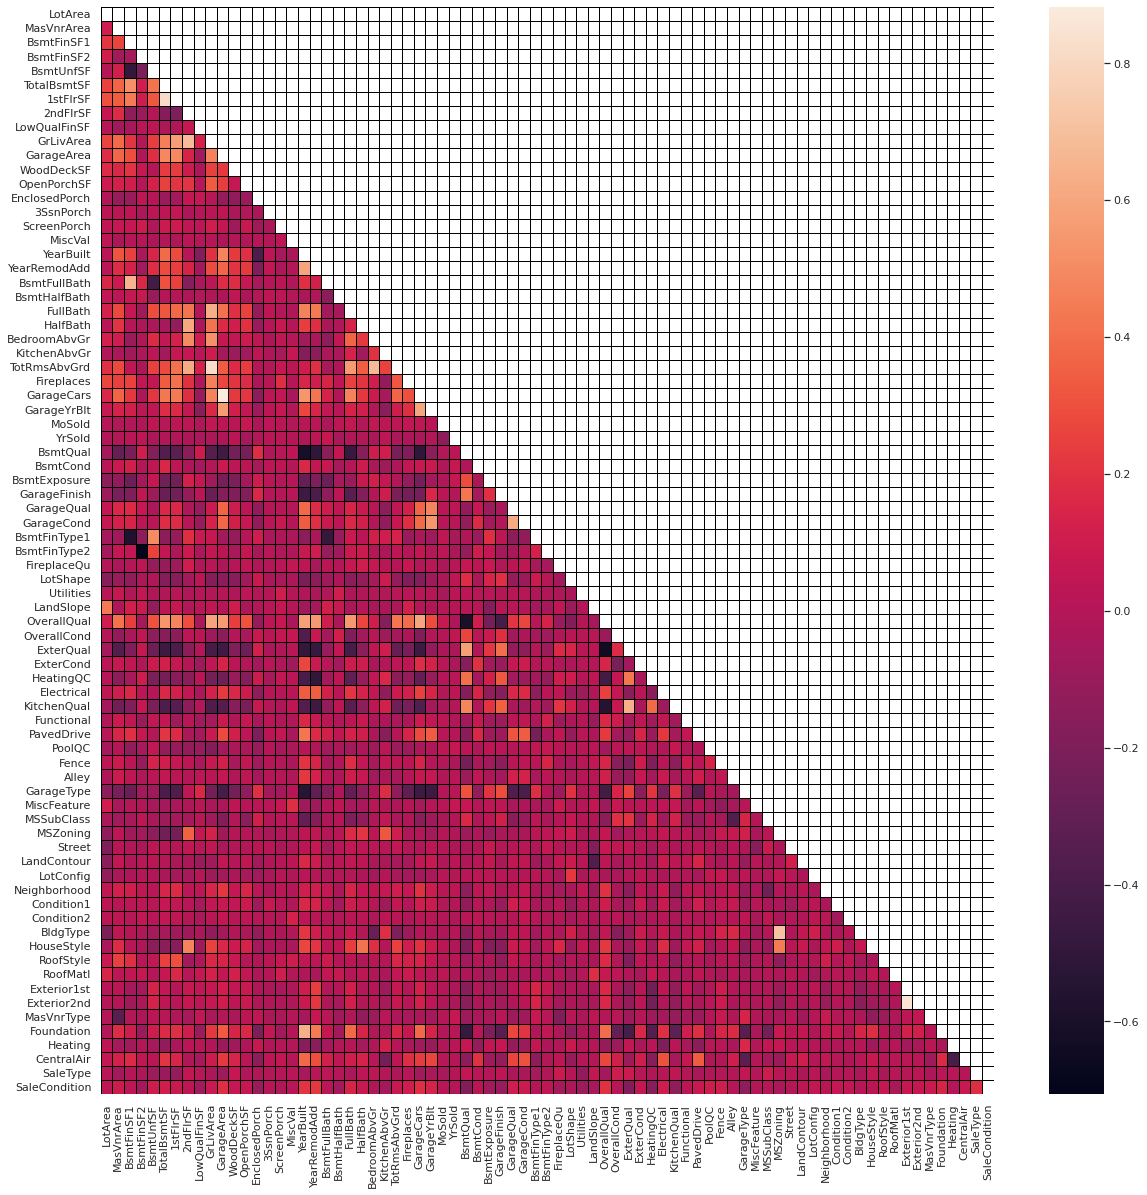

In [56]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(df_concat.corr(), dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(df_concat.corr(), mask=mask, linewidths=1, linecolor='black')
plt.show()

High correlation between features can occur when they are describing attributes that are too similar. When we look at the eight features above the VIF threshold we see two themes, house area and building year. 

`GrLivArea` describes the house ground living area but there are many other features such as `1stFlrSF` and `2ndFlrSF` that also describe house area, but they don't describe it uniquely enough to avoid strong collinearity.

Since `GrLivArea` has a strong correlation with the target feature, it makes sense to drop other features that describe house area in some way but are not as strongly correlated to the target. This would include features such as `FullBath` which would affect the total living area of a house.

As seen in the correlation matrix, `YearBuilt` also struggles from multicollinearity. In this case, we'll try dropping `YearBuilt` and retain the features it shares collinearity with. This is because features like `Foundation` and `PavedDrive` are not similar even though they correlate well with `YearBuilt`.  

`MSZoning` will also be dropped. It has strong correlations to `BldgType` and `HouseStyle`, but a weak correlation to the target feature. 

In [57]:
df_concat = df_concat.drop([
    'WoodDeckSF', 'OpenPorchSF', 'MasVnrArea',
    'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'MSZoning', 'GarageCars', 'GarageArea',
    'FullBath', 'YearBuilt', 'TotRmsAbvGrd'
], axis=1)

df_test_concat = df_test_concat.drop([
    'WoodDeckSF', 'OpenPorchSF', 'MasVnrArea',
    'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'MSZoning', 'GarageCars', 'GarageArea',
    'FullBath', 'YearBuilt', 'TotRmsAbvGrd'
], axis=1)

We've completed our multicollinearity preprocessing, let's run the VIF calculations on the edited training set to see if anything changed.

In [58]:
get_vif(df_concat)

,Feature,VIF
0,const,1.424309e+08
43,MiscFeature,4.283297e+00
7,MiscVal,4.273690e+00
3,GrLivArea,3.959403e+00
55,Exterior1st,3.416393e+00
56,Exterior2nd,3.415299e+00
30,OverallQual,3.119391e+00
2,BsmtFinSF2,2.699827e+00
25,BsmtFinType2,2.539501e+00
1,LotArea,2.505048e+00


The VIF table shows all feature values are now in the acceptable range. Our edits successfully reduced multicollinearity in the data. Now it's time to train our models.

In [59]:
print(df_concat.shape)
df_concat.head()

(1460, 62)


,LotArea,BsmtFinSF2,GrLivArea,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,YearRemodAdd,BsmtFullBath,BsmtHalfBath,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,8450.0,0.0,1710.0,0.0,0.0,0.0,0.0,2003.0,1.0,0.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0
1,9600.0,0.0,1262.0,0.0,0.0,0.0,0.0,1976.0,0.0,1.0,...,1.0,1.0,8.0,8.0,2.0,1.0,1.0,1.0,8.0,4.0
2,11250.0,0.0,1786.0,0.0,0.0,0.0,0.0,2002.0,1.0,0.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0
3,9550.0,0.0,1717.0,272.0,0.0,0.0,0.0,1970.0,1.0,0.0,...,1.0,1.0,13.0,15.0,2.0,0.0,1.0,1.0,8.0,0.0
4,14260.0,0.0,2198.0,0.0,0.0,0.0,0.0,2000.0,1.0,0.0,...,1.0,1.0,12.0,13.0,1.0,2.0,1.0,1.0,8.0,4.0


In [60]:
print(df_test_concat.shape)
df_test_concat.head()

(1459, 62)


,LotArea,BsmtFinSF2,GrLivArea,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,YearRemodAdd,BsmtFullBath,BsmtHalfBath,...,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,SaleType,SaleCondition
0,11622.0,144.0,896.0,0.0,0.0,120.0,0.0,1961.0,0.0,0.0,...,1.0,0.0,10.0,12.0,2.0,1.0,0.0,1.0,8.0,4.0
1,14267.0,0.0,1329.0,0.0,0.0,0.0,12500.0,1958.0,0.0,0.0,...,3.0,0.0,11.0,13.0,1.0,1.0,0.0,1.0,8.0,4.0
2,13830.0,0.0,1629.0,0.0,0.0,0.0,0.0,1998.0,0.0,0.0,...,1.0,0.0,10.0,12.0,2.0,2.0,0.0,1.0,8.0,4.0
3,9978.0,0.0,1604.0,0.0,0.0,0.0,0.0,1998.0,0.0,0.0,...,1.0,0.0,10.0,12.0,1.0,2.0,0.0,1.0,8.0,4.0
4,5005.0,0.0,1280.0,0.0,0.0,144.0,0.0,1992.0,0.0,0.0,...,1.0,0.0,6.0,6.0,2.0,2.0,0.0,1.0,8.0,4.0


## 8.2 Perform Feature Scaling

With the presence of kurtosis throughout the data we'll scale our features using `log(1 + x)`. Our target feature will be scaled using `log(x)`. For prediction, the standard exponential function will be used to return the original price values.

In [61]:
# Scale the features 
X_features = np.log1p(df_concat)
X_test_features = np.log1p(df_test_concat)

In [62]:
Y_labels = df['SalePrice'].astype(float)
print(Y_labels.shape)
Y_labels.head()

(1460,)


0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

# 9. Evaluation of Regression Models

The evaluation function we create will assess our models using ground truth regression plots and return a metric table for root mean squared log error (RMSLE), r-squared, and the cross validation mean.

In [63]:
def evaluate_model(name, model, X_train, Y_train):            
    
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=RANDOM_SEED)    
    # Scale the target feature using log(x)
    model.fit(x_train, np.log(y_train))      
    # Use the exponential function to return predicted sale prices
    pred_train = np.exp(model.predict(x_train))
    pred_val = np.exp(model.predict(x_val))   
    
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, pred_train))
    rmsle_val = np.sqrt(mean_squared_log_error(y_val, pred_val))
    r2_train = r2_score(y_train, pred_train)
    r2_val = r2_score(y_val, pred_val)
    cvs = cross_val_score(model, X_train, np.log(Y_train), cv=5)
    
    # Plot the ground truth 
    f, ax = plt.subplots(figsize=(7, 7))
    plt.scatter(y_train, pred_train, label='Training')
    plt.scatter(y_val, pred_val, label='Validation')  
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
    plt.plot([0, 8e5], [0, 8e5], c='red')
    plt.legend()
    plt.xlabel('Sale Price')
    plt.xticks(rotation=45)
    plt.ylabel('Sale Price')
    plt.title(f'{name}: Ground Truth')
    plt.show()   

    table = pd.DataFrame(
                            [rmsle_train, rmsle_val, r2_train, r2_val, mean(cvs)],
                            index=['RMSLE Training', 'RMSLE Validation', 'R^2 Training', 'R^2 Validation', 'CV Mean'],
                            columns=[name]
    )
    
    return table

We'll define our regressors and evaluate them. Ridge regression will be our baseline model since it can handle multiple features better than a standard linear least squares model.

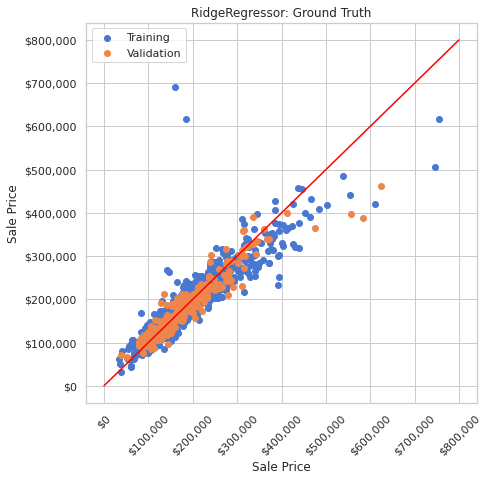

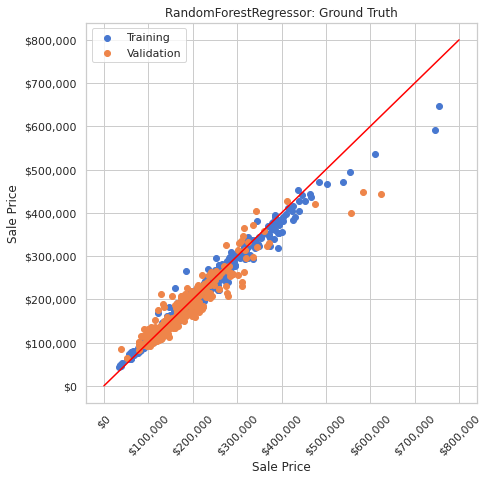

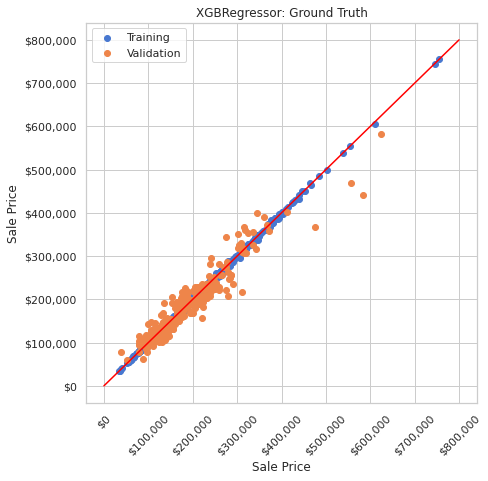

,RidgeRegressor,RandomForestRegressor,XGBRegressor
RMSLE Training,0.142637,0.056579,0.010670
RMSLE Validation,0.127233,0.132864,0.126880
R^2 Training,0.825630,0.976459,0.999327
R^2 Validation,0.877359,0.880809,0.907785
CV Mean,0.863882,0.860121,0.872469


In [64]:
rr = Ridge(random_state=RANDOM_SEED)
rfr = RandomForestRegressor(random_state=RANDOM_SEED)
xgb = XGBRegressor(random_state=RANDOM_SEED)

regressors = [rr, rfr, xgb]
model_names = ['RidgeRegressor','RandomForestRegressor', 'XGBRegressor']
metrics = []

for name, reg in zip(model_names, regressors):
    metrics.append(evaluate_model(name, reg, X_features, Y_labels))

df_results = pd.concat(metrics, axis=1)    
df_results

The best performing model is the `XBGRegressor`. A comparison of the training and validation metrics show some overfitting. To confront this problem we'll try some hyperparameter tuning. We'll select some modest parameters for `GridSearchCV` and see if this improves our model performance.

In [65]:
import time
start_time = time.time()

params = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 6, 9],
    'subsample': [0.5, 0.8]
}

gsearch = GridSearchCV(
    estimator=XGBRegressor(
        learning_rate=0.1,
        # Use GPU Accelerator
        tree_method='gpu_hist', 
        n_jobs=-1,
        random_state=RANDOM_SEED),
    param_grid=params,
    scoring='r2',
    n_jobs=-1,
    cv=5
)

gsearch.fit(X_features, np.log(Y_labels))
print(f'Time Elapsed: {time.time() - start_time}s')

Time Elapsed: 81.51704168319702s


In [66]:
# Display the best parameters for the model and best score
print(f'Best Params: {gsearch.best_params_}')
print(f'Best Score: {gsearch.best_score_}')

Best Params: {'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best Score: 0.8997304558085546


We'll now take the best estimator from `GridSearchCV` and evaluate it with our function.

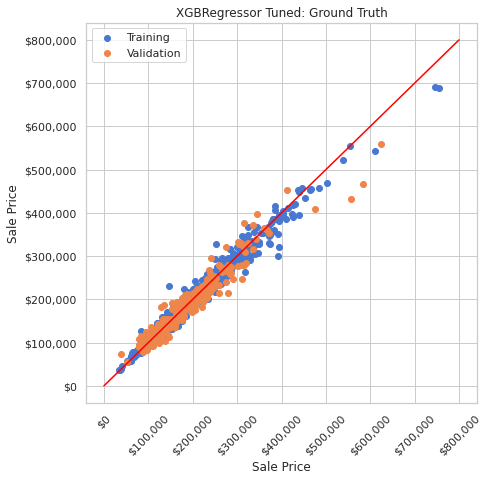

,XGBRegressor Tuned
RMSLE Training,0.060686
RMSLE Validation,0.110243
R^2 Training,0.976657
R^2 Validation,0.927562
CV Mean,0.899730


In [67]:
evaluate_model('XGBRegressor Tuned', gsearch.best_estimator_, X_features, Y_labels)

The plot and metrics table shows a reduction in overfitting. This is only with a modest tuning, where a more aggressive tune could yield better results. We are now ready for the final phase of our data science task.

# 10. Predict Sale Price from the Test Dataset

The best regressor model will be fit on the full training dataset and used to predict house sale prices from the test dataset. Lastly, a table for the predictions will be created and submitted for evaluation.

In [68]:
# Use the best estimator as the regressor
reg = gsearch.best_estimator_
reg.fit(X_features, np.log(Y_labels))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [69]:
# Predict the sale price
predictions = reg.predict(np.log1p(df_test_concat))
# Create a dataframe from sale price predictions and test id column
df_predictions = pd.DataFrame(np.exp(predictions))
df_predictions.columns = ['SalePrice']

submission = pd.concat([df_test['Id'], df_predictions.astype(float)], axis=1)
print(submission.shape)
submission.head()

(1459, 2)


,Id,SalePrice
0,1461,125326.546875
1,1462,164003.437500
2,1463,173961.515625
3,1464,193444.828125
4,1465,185580.437500


In [70]:
submission.to_csv('submission.csv', index=False)